# Exploratory Data Analysis 

As students, we often do not consider Exploratory Data Analysis (EDA) in depth, as our datasets are typically well-curated and features are mostly independent. However, in real-world scenarios, EDA can account for up to 80% of a data scientist’s workload, and for data analysts, it is often their primary focus. A structured approach to EDA can be outlined as follows:

- Univariate analysis and outlier detection
- Multivariate analysis, starting with correlation analysis among numerical features and extending to cross-tabulation of numeric and categorical variables

It is important to formulate hypotheses about your data and validate them, either through statistical techniques or other appropriate methods. 

For example, a hypothesis could be: "The average resale price of 5-room flats is significantly higher than that of 3-room flats." 

To validate this, you could use statistical tests like the independent t-test or ANOVA to compare the means between flat types.

Other appropriate methods for hypothesis validation include data visualization (e.g., box plots, scatter plots to observe distributions and trends), machine learning models to assess feature importance, or domain-driven checks such as consulting policy changes and timelines that could explain variations in the data.


### on domain knowledge:
Domain knowledge provides critical insights into the data that may not be apparent through data analysis techniques alone. For example, policy changes affecting public housing eligibility or pricing can explain shifts or patterns in resale flat prices that are not readily observable from the data itself.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from src.mlp_datapipeline import DataPipeline
from src.mlp import MLPTwoLayers as MLP
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 



with open("statlog_german_credit_metadata.txt", "w") as meta_file:
    for key, value in statlog_german_credit_data.metadata.items():
        meta_file.write(f"{key}:\n")
        if key == 'additional_info' and isinstance(value, dict):
            # Pretty print the additional_info dictionary with proper formatting
            for info_key, info_value in value.items():
                meta_file.write(f"  {info_key}: ")
                if isinstance(info_value, str):
                    # Replace escape sequences with actual newlines and tabs for readability
                    formatted_value = info_value.replace('\\r\\n', '\n').replace('\\t', '    ')
                    meta_file.write(f"\n{formatted_value}\n")
                else:
                    meta_file.write(f"{info_value}\n")
        else:
            meta_file.write(f"{value}")
        meta_file.write("\n\n")
print("Metadata saved to statlog_german_credit_metadata.txt")
  
# variable information 
print(statlog_german_credit_data.variables) 


Metadata saved to statlog_german_credit_metadata.txt
           name     role         type     demographic  \
0    Attribute1  Feature  Categorical            None   
1    Attribute2  Feature      Integer            None   
2    Attribute3  Feature  Categorical            None   
3    Attribute4  Feature  Categorical            None   
4    Attribute5  Feature      Integer            None   
5    Attribute6  Feature  Categorical            None   
6    Attribute7  Feature  Categorical           Other   
7    Attribute8  Feature      Integer            None   
8    Attribute9  Feature  Categorical  Marital Status   
9   Attribute10  Feature  Categorical            None   
10  Attribute11  Feature      Integer            None   
11  Attribute12  Feature  Categorical            None   
12  Attribute13  Feature      Integer             Age   
13  Attribute14  Feature  Categorical            None   
14  Attribute15  Feature  Categorical           Other   
15  Attribute16  Feature      Integ

In [3]:
# Print the shapes
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (1000, 20)
Labels shape: (1000, 1)


In [ ]:
from ydata_profiling import ProfileReport 
# Combine features and target for profiling
data_combined = X.copy()
data_combined['class'] = y

# Save combined dataset to data/raw
os.makedirs("data/raw", exist_ok=True)
data_combined.to_csv("data/raw/german_credit_combined.csv", index=False)

# Generate profile report
profile = ProfileReport(data_combined, title="German Credit Data Profiling Report", explorative=True)
profile.to_file("german_credit_profile_report.html")


### Do your train-test split before transforming your data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      
    random_state=42,    
    stratify=y  
)

### Instantiate your pipeline and transform your data

In [ ]:
pipeline = DataPipeline()
X_train_transformed, y_train_transformed = pipeline.fit_transform(X_train, y_train)
X_test_transformed, y_test_transformed = pipeline.transform(X_test, y_test)

# Save transformed data to data/processed
os.makedirs("data/processed", exist_ok=True)
pd.DataFrame(X_train_transformed).to_csv("data/processed/X_train_transformed.csv", index=False)
pd.DataFrame(y_train_transformed).to_csv("data/processed/y_train_transformed.csv", index=False)
pd.DataFrame(X_test_transformed).to_csv("data/processed/X_test_transformed.csv", index=False)
pd.DataFrame(y_test_transformed).to_csv("data/processed/y_test_transformed.csv", index=False)

### Instantiate your model class with the appropriate parameters

In [7]:
model = MLP(input_size=X_train_transformed.shape[1], hidden_size=64, output_size=2, learning_rate=3e-4)

### Utilise the `Forward` method to take the set of features and return the probabilities of each class for that input datapoint

In [8]:
preds = model.forward(X_train_transformed[[0]])
print(f"Predictions on 1st sample: {preds}")



Predictions on 1st sample: [[0.83216685 0.16783315]]


### Utilise the `loss` method, which takes in the predicted probability and actual label and returns the loss for that input datapoint

In [9]:
train_loss = model.loss(preds, y_train_transformed[[0]])
print(f"Train loss on 1st sample: {train_loss}")

Train loss on 1st sample: 1.7847849608798516


### Utilise the `backward` method to update weights and biases using gradient descent

In [10]:
# calculating the value of the loss function before backpropagation
# Our optimiser is stochastic gradient descent (SGD) since the model is being updated after
# each individual sample (batch_size=1). The script iterates through samples
# one by one, computes the forward pass, calculates loss, and immediately
# calls backward() to update weights for each sample before moving to the next.
test_loss = 0
for i in range(X_test_transformed.shape[0]):
    test_loss += model.loss(model.forward(X_test_transformed[[i]]), y_test_transformed[[i]])
    model.backward(y_test_transformed[[i]])
print(f"Test loss: {test_loss / X_test_transformed.shape[0]}")

Test loss: 0.6567334049742574


### Calculate test loss after training (post-backpropagation)


In [11]:
# Calculate final test loss
test_loss = 0
for i in range(X_test_transformed.shape[0]):
    test_loss += model.loss(model.forward(X_test_transformed[[i]]), y_test_transformed[[i]])
print(test_loss / X_test_transformed.shape[0])

0.6464969244073576


Now suppose we want to run 100 epochs of training. We can do this by iterating through the training data 100 times and updating the model's weights and biases after each epoch.

In [12]:
n_epochs = 500
train_losses = []
test_losses = []

for epoch in range(n_epochs):
        # Training
        epoch_train_loss = 0
        for i in range(X_train_transformed.shape[0]):
            preds = model.forward(X_train_transformed[[i]])
            epoch_train_loss += model.loss(preds, y_train_transformed[[i]])
            model.backward(y_train_transformed[[i]])
        train_losses.append(epoch_train_loss / X_train_transformed.shape[0])

        # Test loss (no backward pass)
        epoch_test_loss = 0
        for i in range(X_test_transformed.shape[0]):
            preds = model.forward(X_test_transformed[[i]])
            epoch_test_loss += model.loss(preds, y_test_transformed[[i]])
        test_losses.append(epoch_test_loss / X_test_transformed.shape[0])
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: Train={train_losses[-1]:.4f}, Test={test_losses[-1]:.4f}")

Epoch 10: Train=0.6067, Test=0.6055
Epoch 20: Train=0.5912, Test=0.5893
Epoch 30: Train=0.5791, Test=0.5771
Epoch 40: Train=0.5691, Test=0.5675
Epoch 50: Train=0.5604, Test=0.5596
Epoch 60: Train=0.5528, Test=0.5530
Epoch 70: Train=0.5460, Test=0.5472
Epoch 80: Train=0.5398, Test=0.5422
Epoch 90: Train=0.5340, Test=0.5378
Epoch 100: Train=0.5288, Test=0.5339
Epoch 110: Train=0.5240, Test=0.5304
Epoch 120: Train=0.5195, Test=0.5273
Epoch 130: Train=0.5154, Test=0.5244
Epoch 140: Train=0.5116, Test=0.5219
Epoch 150: Train=0.5081, Test=0.5196
Epoch 160: Train=0.5049, Test=0.5175
Epoch 170: Train=0.5020, Test=0.5155
Epoch 180: Train=0.4992, Test=0.5137
Epoch 190: Train=0.4967, Test=0.5121
Epoch 200: Train=0.4944, Test=0.5106
Epoch 210: Train=0.4922, Test=0.5091
Epoch 220: Train=0.4902, Test=0.5078
Epoch 230: Train=0.4883, Test=0.5065
Epoch 240: Train=0.4866, Test=0.5053
Epoch 250: Train=0.4849, Test=0.5042
Epoch 260: Train=0.4834, Test=0.5031
Epoch 270: Train=0.4819, Test=0.5021
Epoch 280:

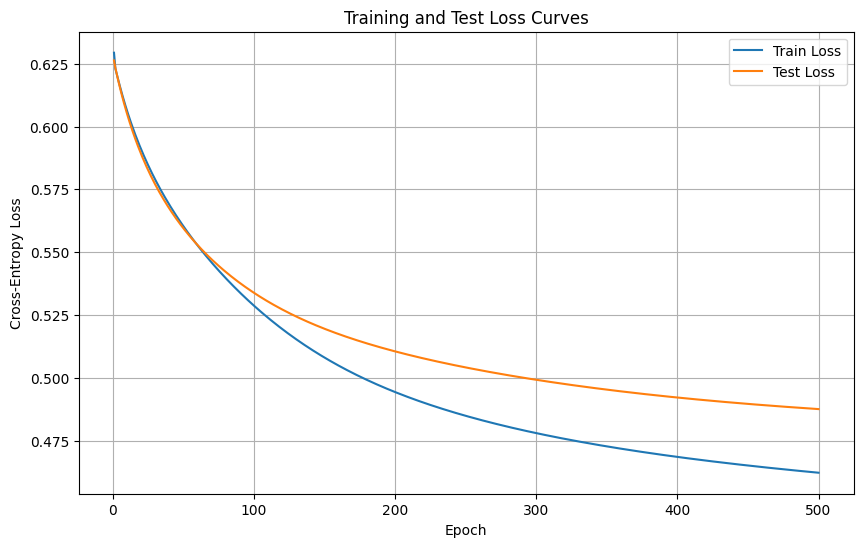

In [13]:
# plotting your loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

How do we interpret our Training and Test loss curves?

* between epoch 0-100 both losses decrease together (model is learning generalizable patterns)
* epoch 100-200 curves start to diverge (model begins to memorize training data)
* epoch 200 and beyond train loss keeps decreasing but test loss plateaus (model is overfit)

a practical takeaway would be to consider **early stopping** - saving the model weights when the test loss stops improving 

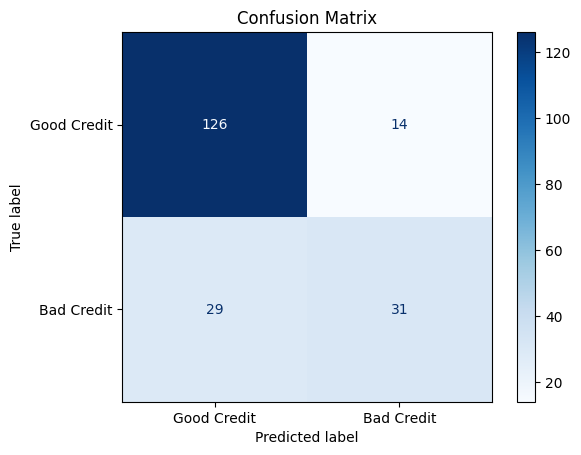

Test Accuracy: 78.50%


In [15]:
# confusion matrix
y_pred = []
for i in range(X_test_transformed.shape[0]):
    preds = model.forward(X_test_transformed[[i]])
    y_pred.append(np.argmax(preds))

y_pred = np.array(y_pred)

cm = confusion_matrix(y_test_transformed, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Good Credit', 'Bad Credit'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

accuracy = np.mean(y_pred == y_test_transformed)
print(f"Test Accuracy: {accuracy:.2%}")